<a href="https://colab.research.google.com/github/EmanoneL/data_analysis_pet_project/blob/main/analysis_of_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [ ]:
import pandas as pd # Для работы с DataFrame
import numpy as np # Для математических операций с DataFrame
import matplotlib.pyplot as plt # Для работы с графиками и гистограммами
import scipy.stats as stats # Некоторые функции для работы со статистикой
import seaborn as sns # Для ящика с усами
from scipy.stats import kstest # Критерий Колмогорова-Смирнова
from scipy.stats import chi2_contingency # Критерий хи-квадрат

## Пользовательские функции


In [ ]:
# Формирует новый столбец(фичу) в DataFrame по данным из столбца price_doc
def price_doc_to_class(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X['class'] = ''

    X.loc[(y <= 3000000), 'class'] = 'cheap'
    X.loc[(y > 3000000) & (y <= 11000000), 'class'] = 'normal'
    X.loc[y > 11000000, 'class'] = 'expensive'

    X = pd.concat([X, y], axis=1)
    return X

In [ ]:
# Формирует новый столбец(фичу) в DataFrame по данным из столбца full_sq для дисперсионного анализа
def full_sq_to_class(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X['full_sq_category'] = ''

    X.loc[(X['full_sq'] <= 30), 'full_sq_category'] = 'small'
    X.loc[(X['full_sq'] > 30) & (X['full_sq'] <= 50), 'full_sq_category'] = 'normal'
    X.loc[(X['full_sq'] > 50) & (X['full_sq'] <= 70), 'full_sq_category'] = 'big'
    X.loc[X['full_sq'] > 70, 'full_sq_category'] = 'large'

    X = pd.concat([X, y], axis=1)
    return X

In [ ]:
# Проверяет близость к нормальному распределению для фичи по критерию Колмогорова-Смирнова
def checkStandart(df, feature_name):
  data = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()

  # Выполняем K-S тест для проверки нормальности
  stat, p_value = kstest(data, 'norm')
  print(f'Statistic: {stat}, p-value: {p_value}')

  # Интерпретация результата
  alpha = 0.05
  if p_value > alpha:
      print('Распределение близко к нормальному (не отклоняем H0)')
  else:
      print('Распределение отличается от нормального (отклоняем H0)')

In [ ]:
def breushPaganTest(X, y):
  X_const = sm.add_constant(X)
  model_sm = sm.OLS(y, X_const).fit()
  test_stat, p_value, _, _ = het_breuschpagan(model_sm.resid, model_sm.model.exog)

  print(f'Test Statistic: {test_stat}')
  print(f'p-value: {p_value}')

  if p_value < 0.05:
      print("Отвергаем нулевую гипотезу: наличие гетероскедастичности.")
  else:
      print("Не отвергаем нулевую гипотезу: гомоскедастичность сохраняется.")

## Загрузка датасета

In [ ]:
df = pd.read_csv('dataset.csv', index_col=0) # Загружаем файл в DataFrame
df.head(10) # Выводим первые 10 результатов

,full_sq,build_type,price_doc
0,43,modern,5533460.0
1,66,brezh,9900000.0
2,55,brezh,1990000.0
3,45,hrush,6500000.0
4,43,hrush,8500000.0
5,91,modern,15500000.0
6,28,brezh,2544340.0
7,38,brezh,2000000.0
8,31,brezh,990000.0
9,44,brezh,8600000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5048 entries, 0 to 5047
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_sq     5048 non-null   int64  
 1   build_type  5048 non-null   object 
 2   price_doc   5047 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.8+ KB


Заметим сразу, что в выборке нет пропусков

**Описание датасета**

* **full_sq** - общая площадь
* **build_year** - год постройки
* **price_doc** - цена квартиры

#Дескриптивный анализ

array([[<Axes: title={'center': 'full_sq'}>,
        <Axes: title={'center': 'price_doc'}>]], dtype=object)

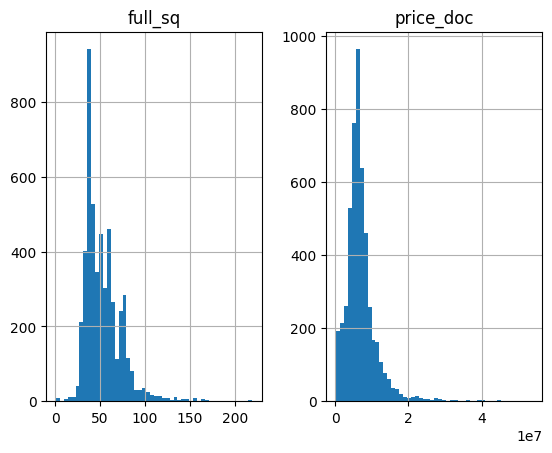

In [ ]:
df.hist(bins=50)

In [ ]:
df['price_doc'].describe()

,price_doc
count,5.047000e+03
mean,7.056259e+06
std,4.480614e+06
min,3.000000e+05
25%,4.687598e+06
50%,6.250000e+06
75%,8.264563e+06
max,5.378714e+07


In [ ]:
df['full_sq'].describe()

,full_sq
count,5048.000000
mean,53.572900
std,20.896383
min,1.000000
25%,38.000000
50%,49.000000
75%,63.000000
max,219.000000


<Axes: xlabel='price_doc'>

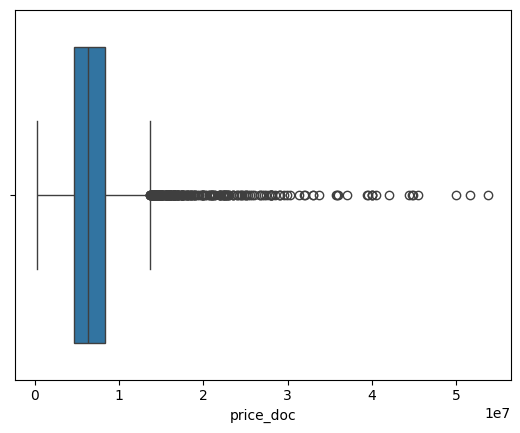

In [ ]:
sns.boxplot(x=df['price_doc'])

<Axes: xlabel='full_sq'>

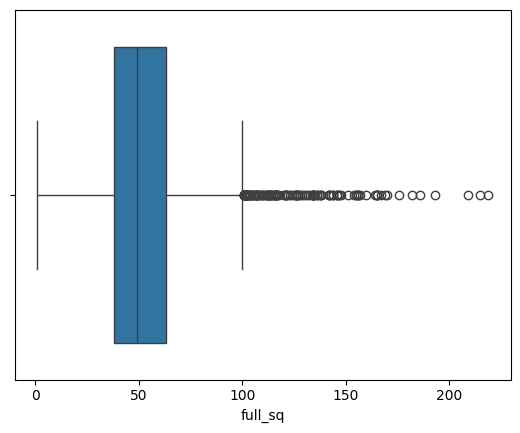

In [ ]:
sns.boxplot(x=df['full_sq'])

In [ ]:
df = df[
    (df['price_doc'] <= df['price_doc'].quantile(0.95))
    & (df['full_sq'] <= df['full_sq'].quantile(0.95))
]

array([[<Axes: title={'center': 'full_sq'}>,
        <Axes: title={'center': 'price_doc'}>]], dtype=object)

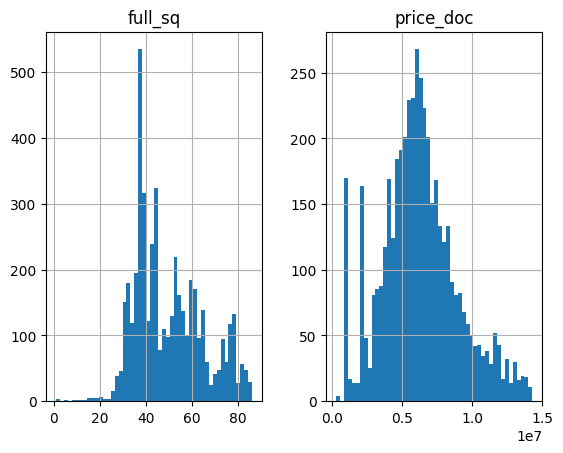

In [ ]:
df.hist(bins=50)

In [ ]:
df.describe()

,full_sq,price_doc
count,4668.000000,4.668000e+03
mean,49.915596,6.262458e+06
std,14.943539,2.724044e+06
min,1.000000,3.000000e+05
25%,38.000000,4.550000e+06
50%,46.000000,6.051250e+06
75%,60.000000,7.750000e+06
max,86.000000,1.430000e+07


In [ ]:
checkStandart(df, 'full_sq')

Statistic: 0.12440248264296977, p-value: 2.003385252551637e-63
Распределение отличается от нормального (отклоняем H0)


In [ ]:
checkStandart(df, 'price_doc')

Statistic: 0.056612411744140334, p-value: 1.9107563092295784e-13
Распределение отличается от нормального (отклоняем H0)


In [ ]:
from scipy.stats import spearmanr

# Применям ранговую корреляцию Спирмана, так как распределение не нормальное
corr, p_value = spearmanr(df['price_doc'], df['full_sq'])
print(f"Spearman's correlation: {corr}, p-value: {p_value}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print('Корреляция значима (отклоняем H0)')
else:
    print('Корреляция незначима (не отклоняем H0)')

Spearman's correlation: 0.431516972695883, p-value: 4.583669083144677e-211
Корреляция значима (отклоняем H0)


In [ ]:
df2 = price_doc_to_class(df) # Добавляем категориальную переменную

In [ ]:
# Строим таблицу сопряженности
contingency_table = pd.crosstab(df2['build_type'], df2['class'])
print(contingency_table)

class       cheap  expensive  normal
build_type                          
brezh         263        107    2121
hrush         109         44     775
modern        134        126     800
stal           16         22     151


In [ ]:
# Критерий хи-квадрат для проверки статистической гипотезы о независимости этих переменных
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - существует связь между переменными.")
else:
    print("Не отвергаем нулевую гипотезу - связи между переменными не обнаружено.")

Chi-square statistic: 92.26716804805791
p-value: 1.0239185405985243e-17
Degrees of freedom: 6
Expected frequencies:
 [[ 278.55655527  159.55634105 2052.88710368]
 [ 103.77377892   59.44130249  764.78491859]
 [ 118.53470437   67.89631534  873.56898029]
 [  21.13496144   12.10604113  155.75899743]]
Отвергаем нулевую гипотезу - существует связь между переменными.


## Дисперсионный анализ

Нулевая гипотеза (H0): Средние значения цены квартир для различных типов домов не отличаются, то есть все группы имеют одинаковое среднее значение.


Альтернативная гипотеза (H1): Средние значения цены квартир отличаются хотя бы для одной из групп типов домов.




In [ ]:
grouped_data = [df[df['build_type'] == group]['price_doc'] for group in df['build_type'].unique()]

# Проведение однофакторного дисперсионного анализа ANOVA
f_stat, p_value = stats.f_oneway(*grouped_data)

# Вывод результатов
print(f"F-статистика: {f_stat}")
print(f"p-значение: {p_value}")

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения цен отличаются.")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения цен не отличаются.")

F-статистика: 36.31003684632008
p-значение: 3.4484712306815347e-23
Отвергаем нулевую гипотезу. Средние значения цен отличаются.


##Двухфакторный дисперсионный анализ

H0 (нулевая гипотеза): Фактор тип дома не оказывает влияния на цену квартиры

H1 (альтернативная гипотеза): Фактор тип дома оказывает влияние на цену квартиры

H0 (нулевая гипотеза): Фактор площадь не оказывает влияния на цену квартиры

H1 (альтернативная гипотеза): Фактор площадь оказывает влияние на цену квартиры

H0 (нулевая гипотеза): Нет эффектов взаимодействия типа квартиры и площади на цену

H1 (альтернативная гипотеза): Есть эффекты взаимодействия типа квартиры и площади на цену

Поделим переменную полщадь квартиры на градации:

Маленькие квартиры: площадь меньше 30 кв.м.

Средние квартиры: площадь от 30 до 50 кв.м.

Большие квартиры: площадь от 50 до 70 кв.м.

Очень большие квартиры: площадь более 70 кв.м.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Применяем функцию к столбцу full_sq
df3 = full_sq_to_class(df)

# Модель двухфакторного дисперсионного анализа (тип дома + категория площади)
model = ols('price_doc ~ C(build_type) + C(full_sq_category) + C(build_type):C(full_sq_category)', data=df3).fit()

# Проведение ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Вывод результатов
print(anova_table)

# Интерпретация результатов
alpha = 0.05
if anova_table["PR(>F)"].iloc[0] < alpha:
    print("Тип дома имеет значительное влияние на цену.")
else:
    print("Тип дома не оказывает значительного влияния на цену.")

if anova_table["PR(>F)"].iloc[1] < alpha:
    print("Категория площади квартиры оказывает значительное влияние на цену.")
else:
    print("Категория площади квартиры не оказывает значительного влияния на цену.")

if anova_table["PR(>F)"].iloc[2] < alpha:
    print("Есть значимое взаимодействие между типом дома и категорией площади квартиры.")
else:
    print("Взаимодействие между типом дома и категорией площади квартиры незначительно.")

                                         sum_sq      df           F  \
C(build_type)                      1.024147e+15     3.0   58.875533   
C(full_sq_category)                6.665382e+15     3.0  383.175524   
C(build_type):C(full_sq_category)  2.013179e+14     9.0    3.857747   
Residual                           2.697402e+16  4652.0         NaN   

                                          PR(>F)  
C(build_type)                       2.377354e-37  
C(full_sq_category)                2.066785e-222  
C(build_type):C(full_sq_category)   6.960405e-05  
Residual                                     NaN  
Тип дома имеет значительное влияние на цену.
Категория площади квартиры оказывает значительное влияние на цену.
Есть значимое взаимодействие между типом дома и категорией площади квартиры.


<Figure size 1000x600 with 0 Axes>

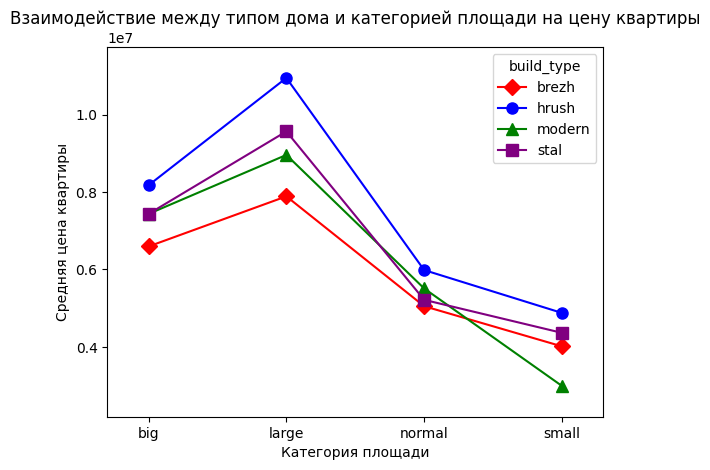

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot


# График для визуализации взаимодействия между типом дома и категорией площади
plt.figure(figsize=(10, 6))
interaction_plot(df3['full_sq_category'], df3['build_type'], df3['price_doc'],
                 colors=['red', 'blue', 'green', 'purple'], markers=['D', 'o', '^', 's'], ms=8)
plt.title('Взаимодействие между типом дома и категорией площади на цену квартиры')
plt.xlabel('Категория площади')
plt.ylabel('Средняя цена квартиры')
plt.show()
